# CNN Autoencoder 

In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import random, math
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

from matplotlib import colors, pyplot as plt





In [2]:
import numpy as np
import os
!pip install scipy==1.1.0
from scipy.misc import imread, imresize
import pandas as pd

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: imresize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [3]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
N_CHANNELS = 3


TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE

print(data.shape)
print(attrs.shape)

smiling_idx = np.argwhere(np.array(attrs['Smiling'] > 1.5))
non_smiling_idx = np.argwhere(np.array(attrs['Smiling'] < -1.5))

print(len(smiling_idx))
print(len(non_smiling_idx))

(13143, 45, 45, 3)
(13143, 73)
1282
1414


In [4]:
X_train = data[:TRAIN_SIZE]

print(X_train.shape)
X_val = data[:VAL_SIZE]
print(X_val.shape)


from google.colab import drive
drive.mount('/content/gdrive/')

(10000, 45, 45, 3)
(3143, 45, 45, 3)
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


Helper-function to plot our faces

In [5]:
def plot_gallery(images, h, w, n_row=3, n_col=10, dim = 3):

  
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        
        plt.imshow(images[i].reshape((h, w, dim)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        


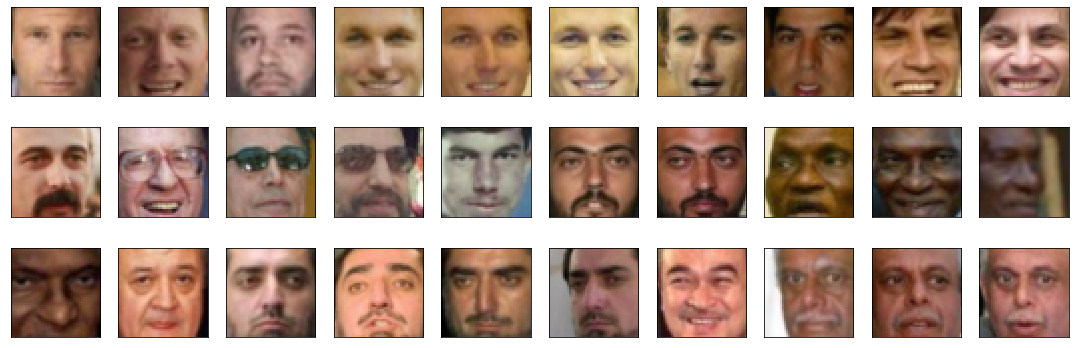

In [6]:
plot_gallery(X_train, 45, 45)

Custom dataset-class to preprocces and feed aour images


In [7]:
class AEDataset(Dataset):

    def __init__(self, file, denoiser = False ):
        super().__init__()

        self.files = file
        self.len_ = file.shape[0]
        self.noise_factor = 0.5
        self.denoiser = denoiser
                      
    def __len__(self):
        return self.len_

    def __getitem__(self, index):
      
        transform = transforms.Compose([
            transforms.ToTensor()
        ])

        x = self.files[index]
        if self.denoiser == False:
            x = transform(x)
            return x
        else:
            x_noisy = x + self.noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
            x_noisy = transform(x_noisy)
            x_grtr = transform(x)
            return x_noisy, x_grtr

## Vanilla and Variational Autoencoder based on CNN




In [8]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
!nvidia-smi
import torch
torch.cuda.is_available()

CUDA is available!  Training on GPU ...
Mon Aug 31 10:07:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                

True

In [9]:
class Autoencoder(nn.Module):    
    def __init__(self, latent_size, VAE = False):
        super().__init__()
        self.latent_size = latent_size
        self.VAE = VAE
        
        # Encoder
        self.enc_conv_1 = nn.Conv2d(3, 96, 3, stride=1, padding=1)
        self.enc_conv_2 = nn.Conv2d(96, 96, 3, stride=1)
        

        self.pool1 = nn.MaxPool2d(2,2)

        self.enc_conv_3 = nn.Conv2d(96, 128, 3, stride=1, padding=1)
        self.enc_conv_4 = nn.Conv2d(128, 128, 3, stride=1)

        self.bn1 = nn.BatchNorm2d(128)

        self.pool2 = nn.MaxPool2d(2,2)

        self.enc_conv_5 = nn.Conv2d(128, 256, 3, stride=1)
        self.enc_conv_52 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.enc_conv_6 = nn.Conv2d(256, 256, 3, stride=1)

        self.bn2 = nn.BatchNorm2d(256)

        self.enc_conv_7 = nn.Conv2d(256, 256, 3, stride=1)

        if self.VAE == False:
            self.enc_lin = nn.Linear(256*3*3, latent_size)
        else:
            self.enc_lin1 = nn.Linear(256*3*3, latent_size)
            self.enc_lin2 = nn.Linear(256*3*3, latent_size)


        # Decoder
        
        self.dec_lin = nn.Linear(latent_size, 256*3*3)

        self.dec_conv_1 = nn.ConvTranspose2d(256, 128, 11, stride=8)
        self.dec_conv_12 = nn.Conv2d(128, 128, 3, stride=1, padding = 1)
        self.dec_conv_2 = nn.ConvTranspose2d(128, 128, 5, stride=1)

        self.bn3 = nn.BatchNorm2d(128)

        self.dec_conv_3 = nn.ConvTranspose2d(128, 128, 5, stride=1)  
        self.dec_conv_32 = nn.Conv2d(128, 128, 3, stride=1, padding = 1)
        self.dec_conv_4 = nn.ConvTranspose2d(128, 128, 5, stride=1) 

        self.dec_conv_5 = nn.ConvTranspose2d(128, 256, 3, stride=1)  
        self.dec_conv_52 = nn.Conv2d(256, 256, 3, stride=1, padding = 1)
        self.dec_conv_6 = nn.ConvTranspose2d(256, 256, 3, stride=1)  

        self.dec_conv_7 = nn.Conv2d(256, 256, 3, stride=1, padding = 1)
        self.dec_conv_8 = nn.ConvTranspose2d(256, 3, 3, stride=1)  


    def forward(self, batch):

        if self.VAE == False:
            code = self.encoder_part(batch)
            out = self.decoder_part(code)

            return out, code
        else:
            mu, logvar = self.encoder_part(batch)
            z = self.gaussian_sampler(mu, logvar)
            out = self.decoder_part(z)

            return out, mu, logvar


        

    def encoder_part(self,batch):
        # Encoder part
        out = F.relu(self.enc_conv_1(batch))
        out = F.relu(self.enc_conv_2(out))
        out = self.pool1(out)

        out = F.relu(self.enc_conv_3(out))
        out = F.relu(self.enc_conv_4(out))
        out = self.bn1(out)
        out = self.pool2(out)

        out = F.relu(self.enc_conv_5(out))
        out = F.relu(self.enc_conv_52(out))
        out = F.relu(self.enc_conv_6(out))
        out = self.bn2(out)

        out = F.relu(self.enc_conv_7(out)).view(-1,256*3*3)
        
        if self.VAE == False:
            code = self.enc_lin(out)
            return code
        else:
            mu = self.enc_lin1(out)
            logvar = self.enc_lin2(out)
            return mu, logvar

    def decoder_part(self,code):
        # Decoder part

        code = F.relu(self.dec_lin(code))
        code = code.view(-1,256,3,3)

        out = F.relu(self.dec_conv_1(code))
        out = F.relu(self.dec_conv_12(out))
        out = F.relu(self.dec_conv_2(out))
        out = self.bn3(out)

        out = F.relu(self.dec_conv_3(out))
        out = F.relu(self.dec_conv_32(out))
        out = F.relu(self.dec_conv_4(out))

        out = F.relu(self.dec_conv_5(out))
        out = F.relu(self.dec_conv_52(out))
        out = F.relu(self.dec_conv_6(out))

        out = F.relu(self.dec_conv_7(out))
        out = torch.sigmoid(self.dec_conv_8(out))

        return out


    def gaussian_sampler(self, mu, logvar):

        if self.training:
            std = torch.exp(0.5*logvar)
            eps = std.data.new(std.size()).normal_()
            
            return eps.mul(std).add_(mu)
        else:
            return mu

DEVICE: cuda
learning rate:  0.001
number of epochs: 150
batch_size: 128
latent_size: 500
NORMALIZATION OF LOSS IS PER DATASET ONLY NOT PER DATASET * PIXELS NUMBER
Number of trainable parameters:  12278999


############################################################
Epoch № 1
TRAIN LOSS:  151.8200875


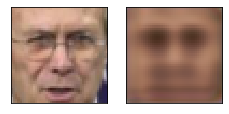

VAL LOSS:  176.26010181355392
current lr:  0.001
############################################################


############################################################
Epoch № 2
TRAIN LOSS:  89.316025


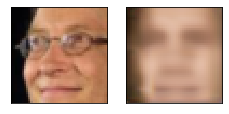

VAL LOSS:  135.34743875278397
current lr:  0.001
############################################################


############################################################
Epoch № 3
TRAIN LOSS:  75.232625


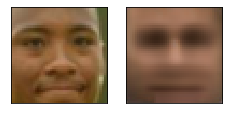

VAL LOSS:  75.14068465637925
current lr:  0.001
############################################################


############################################################
Epoch № 4
TRAIN LOSS:  64.35746875


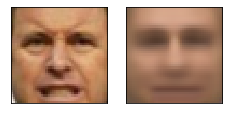

VAL LOSS:  72.10872375119312
current lr:  0.001
############################################################


############################################################
Epoch № 5
TRAIN LOSS:  60.80675625


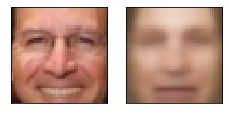

VAL LOSS:  71.76961700604518
current lr:  0.001
############################################################


############################################################
Epoch № 6
TRAIN LOSS:  58.566


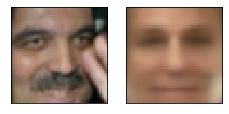

VAL LOSS:  74.17045318962775
current lr:  0.001
############################################################


############################################################
Epoch № 7
TRAIN LOSS:  55.855275


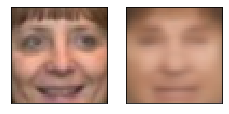

VAL LOSS:  66.46089524339803
current lr:  0.001
############################################################


############################################################
Epoch № 8
TRAIN LOSS:  51.723071875


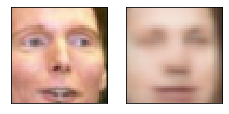

VAL LOSS:  56.68085825644289
current lr:  0.001
############################################################


############################################################
Epoch № 9
TRAIN LOSS:  49.849903125


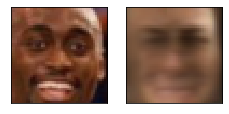

VAL LOSS:  60.232510738148264
current lr:  0.001
############################################################


############################################################
Epoch № 10
TRAIN LOSS:  50.3127875


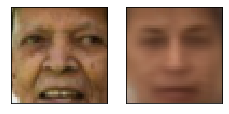

VAL LOSS:  50.658835109767736
current lr:  0.001
############################################################


############################################################
Epoch № 11
TRAIN LOSS:  46.14388125


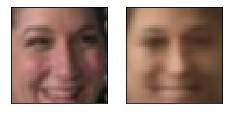

VAL LOSS:  50.604965399300035
current lr:  0.001
############################################################


############################################################
Epoch № 12
TRAIN LOSS:  44.0181875


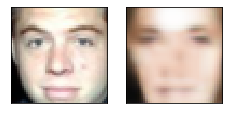

VAL LOSS:  44.325579661151764
current lr:  0.001
############################################################


############################################################
Epoch № 13
TRAIN LOSS:  42.000590625


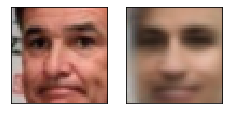

VAL LOSS:  42.753082246261535
current lr:  0.001
############################################################


############################################################
Epoch № 14
TRAIN LOSS:  40.585421875


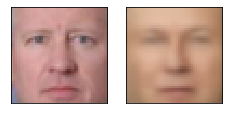

VAL LOSS:  45.038970529748646
current lr:  0.001
############################################################


############################################################
Epoch № 15
TRAIN LOSS:  41.07286875


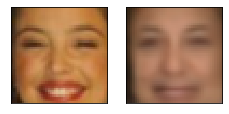

VAL LOSS:  49.19016465160674
current lr:  0.001
############################################################


############################################################
Epoch № 16
TRAIN LOSS:  38.093178125


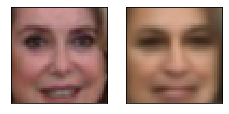

VAL LOSS:  40.42518592904868
current lr:  0.0008
############################################################


############################################################
Epoch № 17
TRAIN LOSS:  37.51923125


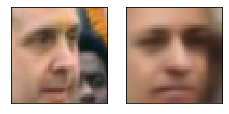

VAL LOSS:  45.24534680241807
current lr:  0.0008
############################################################


############################################################
Epoch № 18
TRAIN LOSS:  36.368321875


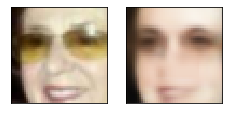

VAL LOSS:  39.2591025692014
current lr:  0.0008
############################################################


############################################################
Epoch № 19
TRAIN LOSS:  35.566190625


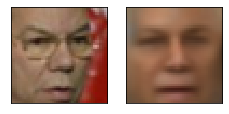

VAL LOSS:  40.99591850938594
current lr:  0.0008
############################################################


############################################################
Epoch № 20
TRAIN LOSS:  35.4859125


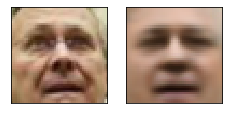

VAL LOSS:  36.58933045657015
current lr:  0.0008
############################################################


############################################################
Epoch № 21
TRAIN LOSS:  34.2798875


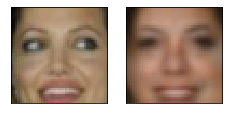

VAL LOSS:  38.822830496341076
current lr:  0.0008
############################################################


############################################################
Epoch № 22
TRAIN LOSS:  32.864159375


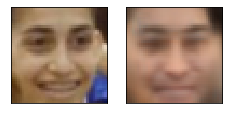

VAL LOSS:  42.07773723353484
current lr:  0.0008
############################################################


############################################################
Epoch № 23
TRAIN LOSS:  30.550228125


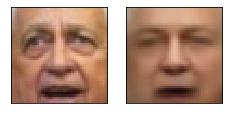

VAL LOSS:  41.658454800349986
current lr:  0.0008
############################################################


############################################################
Epoch № 24
TRAIN LOSS:  29.5584


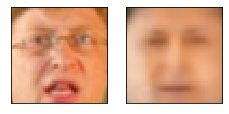

VAL LOSS:  33.533447343302576
current lr:  0.0008
############################################################


############################################################
Epoch № 25
TRAIN LOSS:  28.44664375


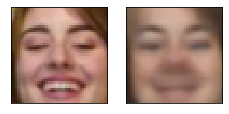

VAL LOSS:  32.19841711740376
current lr:  0.0008
############################################################


############################################################
Epoch № 26
TRAIN LOSS:  27.78769375


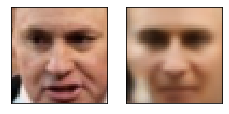

VAL LOSS:  31.591279231625837
current lr:  0.0008
############################################################


############################################################
Epoch № 27
TRAIN LOSS:  27.23126875


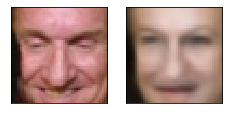

VAL LOSS:  38.641527302736236
current lr:  0.0008
############################################################


############################################################
Epoch № 28
TRAIN LOSS:  27.480090625


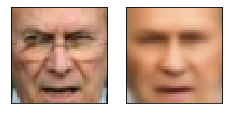

VAL LOSS:  63.277322621699014
current lr:  0.0008
############################################################


############################################################
Epoch № 29
TRAIN LOSS:  26.54141875


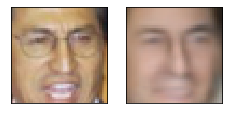

VAL LOSS:  30.511652879414573
current lr:  0.0008
############################################################


############################################################
Epoch № 30
TRAIN LOSS:  24.8892859375


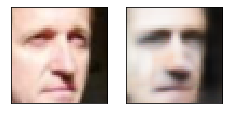

VAL LOSS:  44.37286231307668
current lr:  0.0008
############################################################


############################################################
Epoch № 31
TRAIN LOSS:  24.1236390625


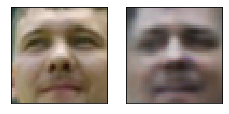

VAL LOSS:  40.04943028157811
current lr:  0.00064
############################################################


############################################################
Epoch № 32
TRAIN LOSS:  24.5568828125


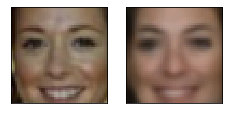

VAL LOSS:  24.675864520362712
current lr:  0.00064
############################################################


############################################################
Epoch № 33
TRAIN LOSS:  22.9445671875


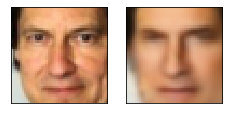

VAL LOSS:  23.240109469455934
current lr:  0.00064
############################################################


############################################################
Epoch № 34
TRAIN LOSS:  23.2118171875


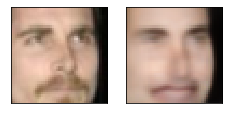

VAL LOSS:  24.669814369233215
current lr:  0.00064
############################################################


############################################################
Epoch № 35
TRAIN LOSS:  22.8674484375


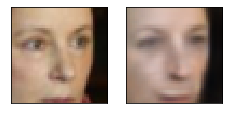

VAL LOSS:  25.55921392777601
current lr:  0.00064
############################################################


############################################################
Epoch № 36
TRAIN LOSS:  22.9582859375


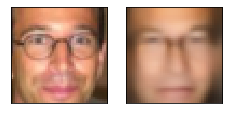

VAL LOSS:  28.665854677060132
current lr:  0.00064
############################################################


############################################################
Epoch № 37
TRAIN LOSS:  22.6007828125


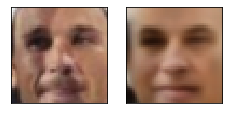

VAL LOSS:  23.583081450843142
current lr:  0.00064
############################################################


############################################################
Epoch № 38
TRAIN LOSS:  22.1581375


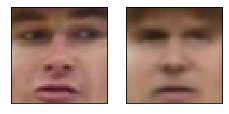

VAL LOSS:  22.47340071189946
current lr:  0.00064
############################################################


############################################################
Epoch № 39
TRAIN LOSS:  21.6999875


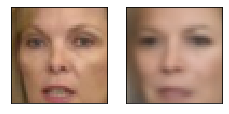

VAL LOSS:  34.001645521794465
current lr:  0.00064
############################################################


############################################################
Epoch № 40
TRAIN LOSS:  21.0623515625


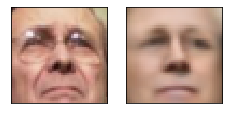

VAL LOSS:  21.933649677855552
current lr:  0.00064
############################################################


############################################################
Epoch № 41
TRAIN LOSS:  20.69395


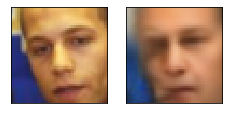

VAL LOSS:  21.31760559179128
current lr:  0.00064
############################################################


############################################################
Epoch № 42
TRAIN LOSS:  20.140025


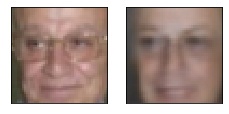

VAL LOSS:  30.790173600063632
current lr:  0.00064
############################################################


############################################################
Epoch № 43
TRAIN LOSS:  19.93981875


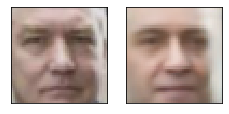

VAL LOSS:  32.45810382198536
current lr:  0.00064
############################################################


############################################################
Epoch № 44
TRAIN LOSS:  19.6072421875


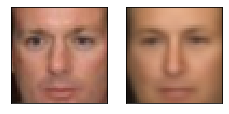

VAL LOSS:  21.472264755011135
current lr:  0.00064
############################################################


############################################################
Epoch № 45
TRAIN LOSS:  19.6174859375


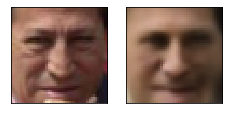

VAL LOSS:  22.31322581928094
current lr:  0.00064
############################################################


############################################################
Epoch № 46
TRAIN LOSS:  18.973359375


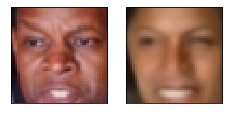

VAL LOSS:  20.998548361438118
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 47
TRAIN LOSS:  18.6513390625


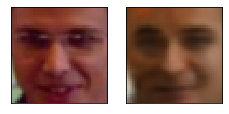

VAL LOSS:  19.980753360642698
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 48
TRAIN LOSS:  18.349565625


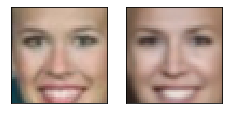

VAL LOSS:  18.43560342427617
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 49
TRAIN LOSS:  18.335059375


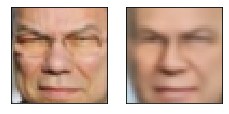

VAL LOSS:  18.746873011454024
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 50
TRAIN LOSS:  18.0832328125


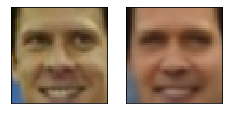

VAL LOSS:  19.898561784123448
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 51
TRAIN LOSS:  17.811446875


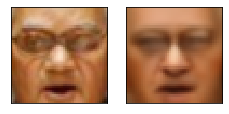

VAL LOSS:  23.87153993000318
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 52
TRAIN LOSS:  17.3642515625


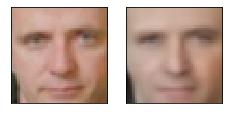

VAL LOSS:  19.353203050429524
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 53
TRAIN LOSS:  17.89456875


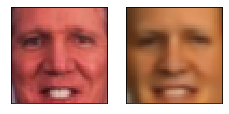

VAL LOSS:  19.27277257993955
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 54
TRAIN LOSS:  17.4056125


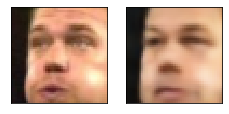

VAL LOSS:  19.560543767896913
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 55
TRAIN LOSS:  17.457646875


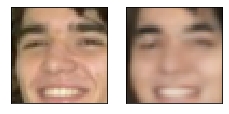

VAL LOSS:  17.482474695752465
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 56
TRAIN LOSS:  16.87375


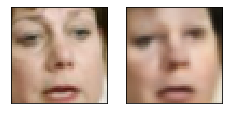

VAL LOSS:  17.341951608733694
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 57
TRAIN LOSS:  16.4321640625


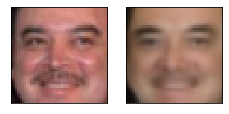

VAL LOSS:  18.312293688355076
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 58
TRAIN LOSS:  17.0922234375


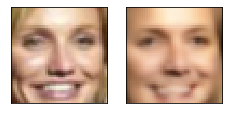

VAL LOSS:  18.174049972160358
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 59
TRAIN LOSS:  16.39100625


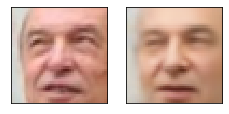

VAL LOSS:  15.995310760022273
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 60
TRAIN LOSS:  16.3266953125


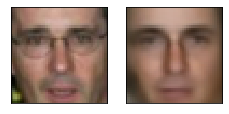

VAL LOSS:  16.856347438752785
current lr:  0.0005120000000000001
############################################################


############################################################
Epoch № 61
TRAIN LOSS:  16.0740453125


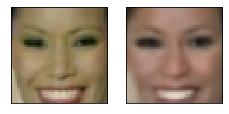

VAL LOSS:  16.427119790009545
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 62
TRAIN LOSS:  15.645346875


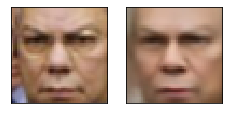

VAL LOSS:  14.861362303133948
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 63
TRAIN LOSS:  15.319721875


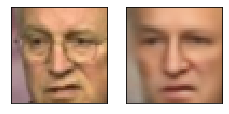

VAL LOSS:  15.121905325326122
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 64
TRAIN LOSS:  15.26190625


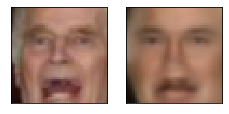

VAL LOSS:  16.146434039930003
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 65
TRAIN LOSS:  15.386809375


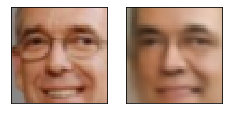

VAL LOSS:  14.25474765351575
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 66
TRAIN LOSS:  14.71088125


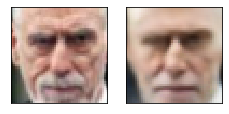

VAL LOSS:  15.540104000954502
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 67
TRAIN LOSS:  14.5877296875


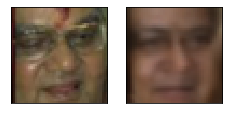

VAL LOSS:  17.63865633948457
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 68
TRAIN LOSS:  14.906990625


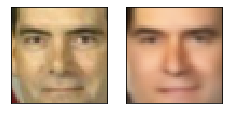

VAL LOSS:  20.681786658845052
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 69
TRAIN LOSS:  14.8092453125


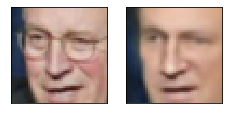

VAL LOSS:  14.774292574769328
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 70
TRAIN LOSS:  14.29175


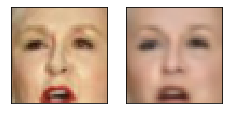

VAL LOSS:  17.514962565622017
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 71
TRAIN LOSS:  14.5667953125


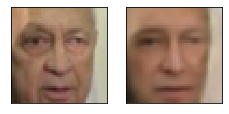

VAL LOSS:  13.816330436684696
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 72
TRAIN LOSS:  14.012296875


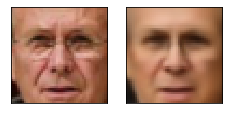

VAL LOSS:  14.70341831053134
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 73
TRAIN LOSS:  14.382703125


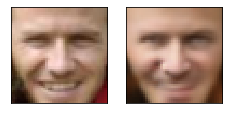

VAL LOSS:  14.791704780464524
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 74
TRAIN LOSS:  14.227278125


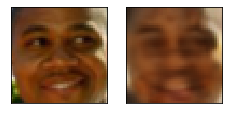

VAL LOSS:  16.334508232580337
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 75
TRAIN LOSS:  14.9583390625


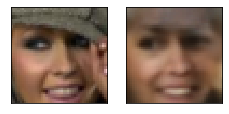

VAL LOSS:  13.350245088291441
current lr:  0.0004096000000000001
############################################################


############################################################
Epoch № 76
TRAIN LOSS:  13.5882171875


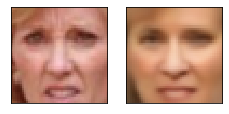

VAL LOSS:  16.886963589723194
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 77
TRAIN LOSS:  13.4323578125


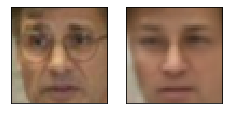

VAL LOSS:  15.4081130190105
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 78
TRAIN LOSS:  13.7049796875


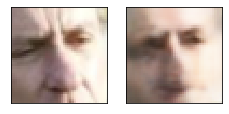

VAL LOSS:  12.911575574689786
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 79
TRAIN LOSS:  12.9633640625


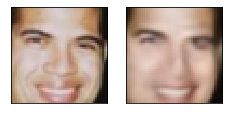

VAL LOSS:  13.271629166003818
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 80
TRAIN LOSS:  13.05959375


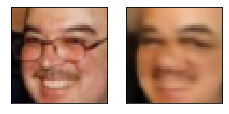

VAL LOSS:  15.664754762567611
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 81
TRAIN LOSS:  12.91294140625


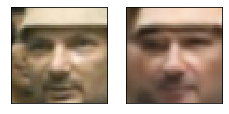

VAL LOSS:  13.415378668867325
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 82
TRAIN LOSS:  12.80321171875


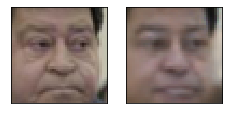

VAL LOSS:  12.668222289611835
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 83
TRAIN LOSS:  12.9334546875


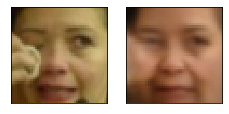

VAL LOSS:  13.219514347359212
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 84
TRAIN LOSS:  12.81580625


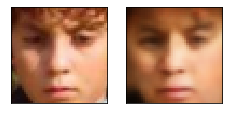

VAL LOSS:  11.982417525055679
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 85
TRAIN LOSS:  12.4263421875


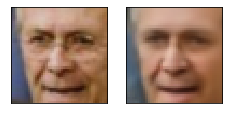

VAL LOSS:  11.68247022152402
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 86
TRAIN LOSS:  12.2748171875


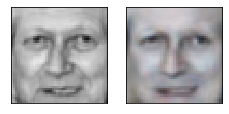

VAL LOSS:  12.5892347577951
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 87
TRAIN LOSS:  12.27524296875


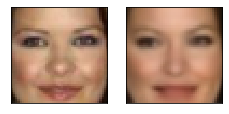

VAL LOSS:  13.13381174435253
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 88
TRAIN LOSS:  12.2779171875


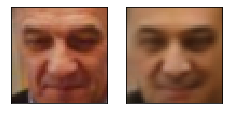

VAL LOSS:  13.488046353006682
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 89
TRAIN LOSS:  12.5562046875


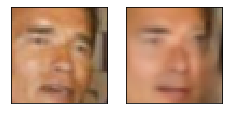

VAL LOSS:  12.93672198138721
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 90
TRAIN LOSS:  12.33601328125


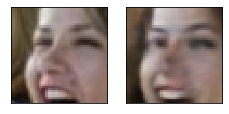

VAL LOSS:  12.19557846802418
current lr:  0.0003276800000000001
############################################################


############################################################
Epoch № 91
TRAIN LOSS:  11.80677578125


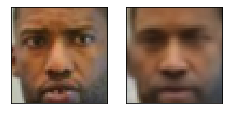

VAL LOSS:  13.366004315144766
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 92
TRAIN LOSS:  11.8750953125


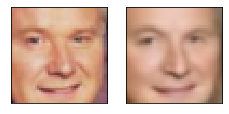

VAL LOSS:  13.87502485682469
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 93
TRAIN LOSS:  11.8120078125


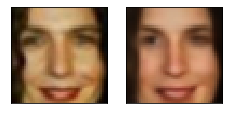

VAL LOSS:  11.08476052935094
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 94
TRAIN LOSS:  11.53404140625


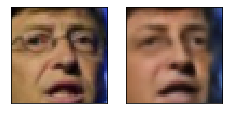

VAL LOSS:  10.988528575405663
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 95
TRAIN LOSS:  11.22387265625


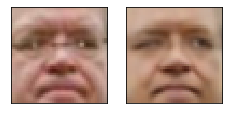

VAL LOSS:  11.126894090041361
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 96
TRAIN LOSS:  11.41575234375


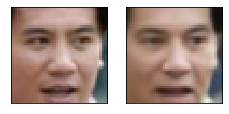

VAL LOSS:  11.694078358654153
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 97
TRAIN LOSS:  11.12648828125


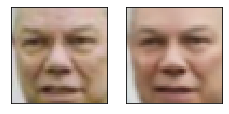

VAL LOSS:  11.00978613188037
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 98
TRAIN LOSS:  11.3722359375


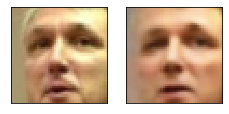

VAL LOSS:  12.625768075882915
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 99
TRAIN LOSS:  11.98688828125


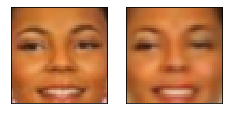

VAL LOSS:  11.482580337257398
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 100
TRAIN LOSS:  11.0677421875


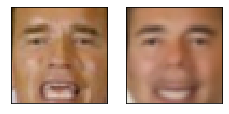

VAL LOSS:  10.666600381800826
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 101
TRAIN LOSS:  10.98796953125


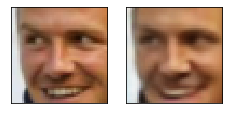

VAL LOSS:  11.127202314667516
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 102
TRAIN LOSS:  10.93271328125


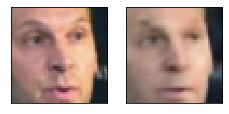

VAL LOSS:  13.388041133073497
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 103
TRAIN LOSS:  11.21622265625


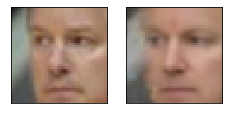

VAL LOSS:  11.29836143811645
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 104
TRAIN LOSS:  10.95424453125


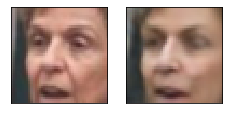

VAL LOSS:  12.394356009385938
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 105
TRAIN LOSS:  11.37484296875


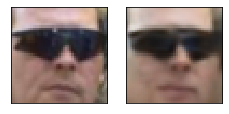

VAL LOSS:  11.13769313752784
current lr:  0.0002621440000000001
############################################################


############################################################
Epoch № 106
TRAIN LOSS:  10.590084375


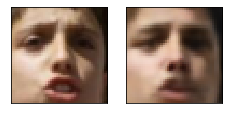

VAL LOSS:  10.629639526328349
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 107
TRAIN LOSS:  10.5770015625


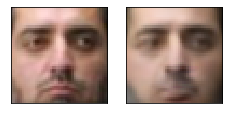

VAL LOSS:  12.3847836461979
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 108
TRAIN LOSS:  10.387975


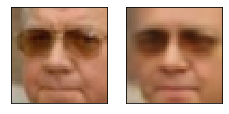

VAL LOSS:  9.991761826877188
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 109
TRAIN LOSS:  10.56247734375


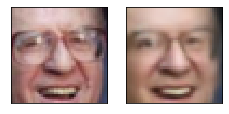

VAL LOSS:  10.00288463450525
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 110
TRAIN LOSS:  10.29271875


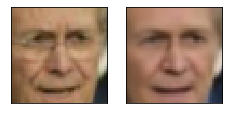

VAL LOSS:  10.315013646396755
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 111
TRAIN LOSS:  10.13655078125


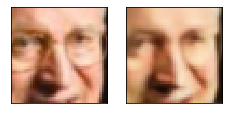

VAL LOSS:  9.859846658248488
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 112
TRAIN LOSS:  10.2878875


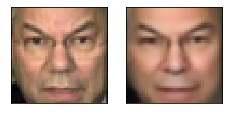

VAL LOSS:  10.219597617721922
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 113
TRAIN LOSS:  10.5036734375


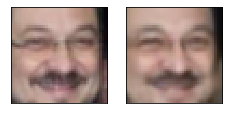

VAL LOSS:  9.56136777163538
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 114
TRAIN LOSS:  10.239953125


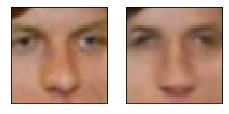

VAL LOSS:  10.273103175707922
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 115
TRAIN LOSS:  9.9735796875


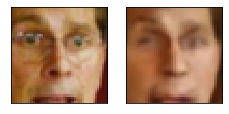

VAL LOSS:  11.604778973114858
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 116
TRAIN LOSS:  10.05046953125


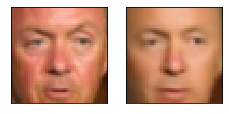

VAL LOSS:  10.117642379891823
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 117
TRAIN LOSS:  10.25987734375


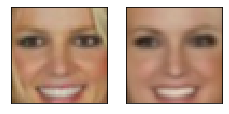

VAL LOSS:  10.026894462893733
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 118
TRAIN LOSS:  10.10159765625


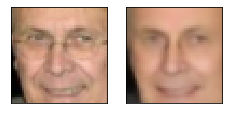

VAL LOSS:  10.117708871897868
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 119
TRAIN LOSS:  10.25133828125


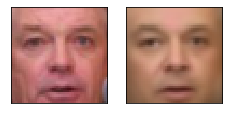

VAL LOSS:  10.089244700524976
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 120
TRAIN LOSS:  10.1310546875


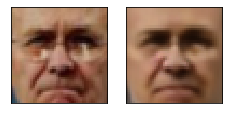

VAL LOSS:  9.600693753977092
current lr:  0.00020971520000000012
############################################################


############################################################
Epoch № 121
TRAIN LOSS:  9.73755


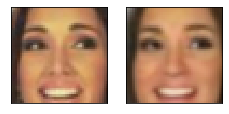

VAL LOSS:  9.331539084871142
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 122
TRAIN LOSS:  9.6475


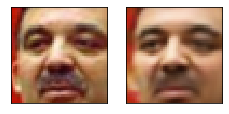

VAL LOSS:  10.589114202195354
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 123
TRAIN LOSS:  9.97127578125


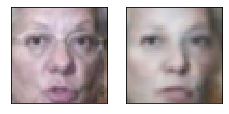

VAL LOSS:  9.058806275851097
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 124
TRAIN LOSS:  9.819340625


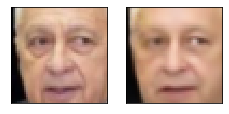

VAL LOSS:  11.260964345370665
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 125
TRAIN LOSS:  9.47398515625


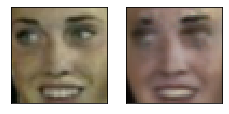

VAL LOSS:  9.842070921492205
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 126
TRAIN LOSS:  9.39755390625


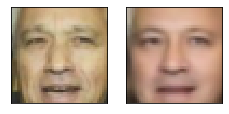

VAL LOSS:  9.391966025692014
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 127
TRAIN LOSS:  9.6635046875


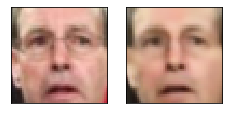

VAL LOSS:  9.36252560252943
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 128
TRAIN LOSS:  9.549540625


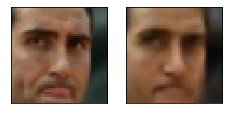

VAL LOSS:  10.723144686605155
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 129
TRAIN LOSS:  9.641675


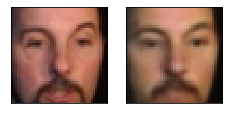

VAL LOSS:  9.189936590240217
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 130
TRAIN LOSS:  9.3781265625


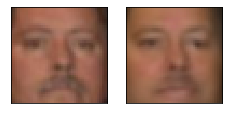

VAL LOSS:  8.909244004533885
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 131
TRAIN LOSS:  9.31969375


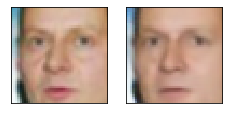

VAL LOSS:  8.821063176105632
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 132
TRAIN LOSS:  9.224215625


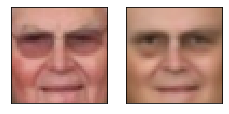

VAL LOSS:  8.837098313713014
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 133
TRAIN LOSS:  9.13876953125


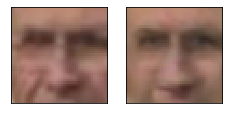

VAL LOSS:  8.86193276726058
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 134
TRAIN LOSS:  9.2608609375


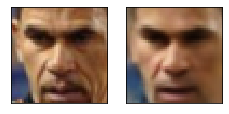

VAL LOSS:  9.175666908606427
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 135
TRAIN LOSS:  9.22966875


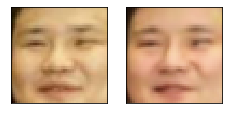

VAL LOSS:  9.906087187798281
current lr:  0.0001677721600000001
############################################################


############################################################
Epoch № 136
TRAIN LOSS:  8.915471875


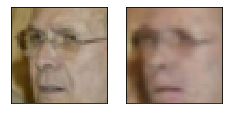

VAL LOSS:  8.638024354716832
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 137
TRAIN LOSS:  9.05693828125


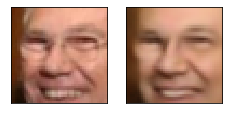

VAL LOSS:  8.488590717467387
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 138
TRAIN LOSS:  9.05575859375


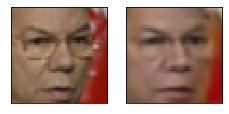

VAL LOSS:  9.133693674435253
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 139
TRAIN LOSS:  8.7835046875


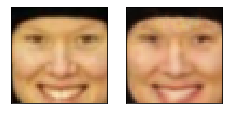

VAL LOSS:  8.175236885539293
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 140
TRAIN LOSS:  8.69039765625


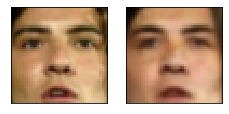

VAL LOSS:  8.257191079382755
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 141
TRAIN LOSS:  9.0381859375


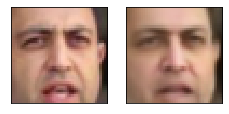

VAL LOSS:  8.832510365295896
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 142
TRAIN LOSS:  8.79113515625


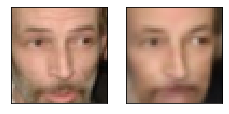

VAL LOSS:  8.64694422625676
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 143
TRAIN LOSS:  8.79720703125


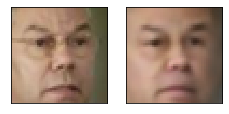

VAL LOSS:  8.487743721166083
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 144
TRAIN LOSS:  8.84338671875


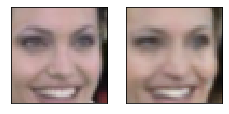

VAL LOSS:  8.448451295537703
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 145
TRAIN LOSS:  8.722328125


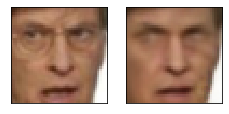

VAL LOSS:  8.306689717228762
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 146
TRAIN LOSS:  8.62376015625


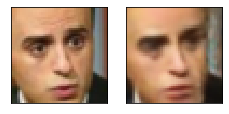

VAL LOSS:  8.43297108654152
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 147
TRAIN LOSS:  8.7856703125


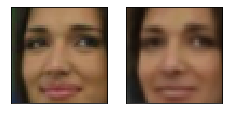

VAL LOSS:  9.318959667316259
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 148
TRAIN LOSS:  8.86748515625


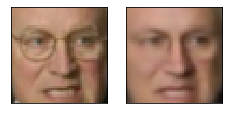

VAL LOSS:  8.293409958638243
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 149
TRAIN LOSS:  8.665775


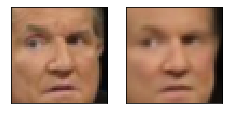

VAL LOSS:  7.963694121858097
current lr:  0.00013421772800000008
############################################################


############################################################
Epoch № 150
TRAIN LOSS:  8.47859296875


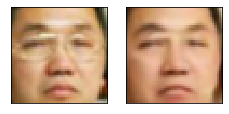

VAL LOSS:  8.364689389118677
current lr:  0.00013421772800000008
############################################################




In [16]:
import random
int = random.randint(0,10)
DEVICE = torch.device("cuda")



learning_rate = 0.001
num_epochs = 150
batch_size = 128
latent_size = 500
print('DEVICE:',DEVICE)
print('learning rate: ', learning_rate)
print('number of epochs:',num_epochs)
print('batch_size:',batch_size)
print('latent_size:',latent_size)
print('NORMALIZATION OF LOSS IS PER DATASET ONLY NOT PER DATASET * PIXELS NUMBER')



model = Autoencoder(latent_size, VAE = False).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: ', total_params)
print('\n')


criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 15, gamma=0.8)


train_dataset = AEDataset(X_train)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = AEDataset(X_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*10, shuffle=True)






history = []
for epoch in range(1,num_epochs+1):
    print('#'*60)
    print("Epoch № %d" % epoch)
    loss_per_epoch = 0
    i = 0
    model.train()
    for batch in dataloader: 
        batch = batch.to(DEVICE) 
        reconstruction, code = model.forward(batch)
        optimizer.zero_grad()
        loss = criterion(reconstruction, batch)
        loss.backward()
        optimizer.step()
        loss_per_epoch += loss
        i+=1



    loss_per_epoch = loss_per_epoch.item() / (X_train.shape[0])
    print('TRAIN LOSS: ', loss_per_epoch)

    with torch.no_grad():
        val_loss_per_epoch = 0
        i = 0
        model.eval()
        for batch in val_dataloader:  
            batch = batch.to(DEVICE)

            reconstruction, code = model.forward(batch)

            loss_val = criterion(reconstruction, batch)
            val_loss_per_epoch += loss_val  
            i+=1 

    
    plot_gallery([batch[int].permute(1, 2, 0).cpu(), reconstruction[int].permute(1, 2, 0).cpu()], 45, 45, n_row=1, n_col=2)
    plt.show()

    val_loss_per_epoch = val_loss_per_epoch.item() / (X_val.shape[0])

    history.append([loss_per_epoch, val_loss_per_epoch])
    print('VAL LOSS: ', val_loss_per_epoch)
    print('current lr: ',scheduler.get_last_lr()[0])
    print('#'*60)
    print('\n')
    scheduler.step()

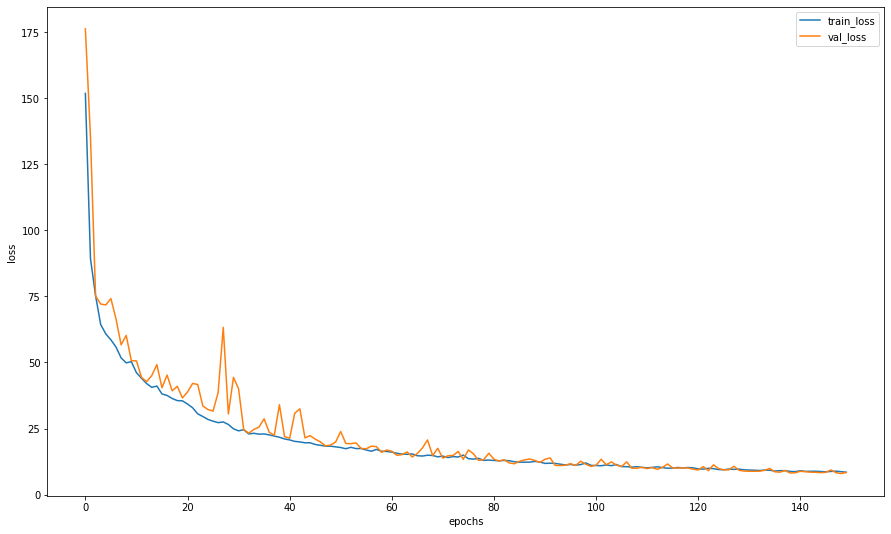

In [17]:
history = np.array(history)
plt.figure(figsize=(15, 9))
plt.plot(history[:,0], label="train_loss")
plt.plot(history[:,1], label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Evaluation how our AE can reconstruct images:


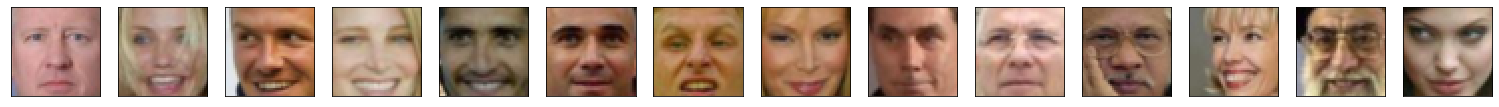

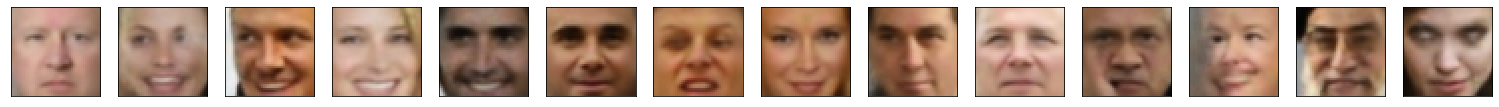

In [18]:
val_dataloader = DataLoader(val_dataset, batch_size=14, shuffle=True)
with torch.no_grad():
    batch_for_watch = next(iter(val_dataloader)).to(DEVICE)
    reconstruction, _ = model.forward(batch_for_watch)

plot_gallery(batch_for_watch.permute(0, 2, 3, 1).cpu(), 45, 45, n_row=1, n_col=14)
plot_gallery(reconstruction.permute(0, 2, 3, 1).cpu(), 45, 45, n_row=1, n_col=14)

Addition of smile-vector to sad person's image

number of smiling guys: 1282
number of sad guys: 1414

How smile vector looks like


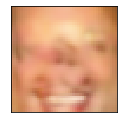

In [19]:
dataset = AEDataset(data)


import random
DEVICE = torch.device("cuda")


val_dataloader = DataLoader(dataset, batch_size=15000)



with torch.no_grad():

    batch_for_smile = next(iter(val_dataloader))[smiling_idx[:,0]].view(-1,3,45,45).to(DEVICE)
    print('number of smiling guys:',batch_for_smile.shape[0])
    z_smiling = torch.mean(model.encoder_part(batch_for_smile),0).view(1,latent_size)


    batch_for_non_smile = next(iter(val_dataloader))[non_smiling_idx[:,0]].view(-1,3,45,45).to(DEVICE)
    print('number of sad guys:',batch_for_non_smile.shape[0])
    z_non_smiling = torch.mean(model.encoder_part(batch_for_non_smile), 0).view(1,latent_size)


    smile_vector = z_smiling - z_non_smiling
    sad_vector = z_non_smiling - z_smiling


    
    smiling = model.decoder_part(smile_vector)

    print('\nHow smile vector looks like')
    plot_gallery(smiling.permute(0, 2, 3, 1).cpu(), 45, 45, n_row=1, n_col=1)



sad people


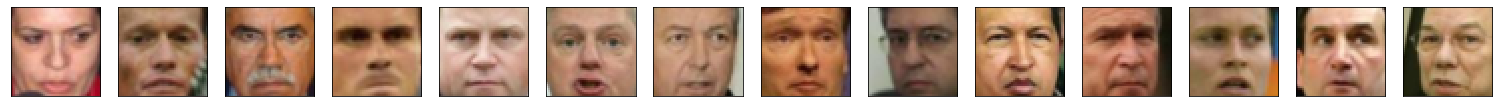

let's look at ability of our decoder to reconstruct


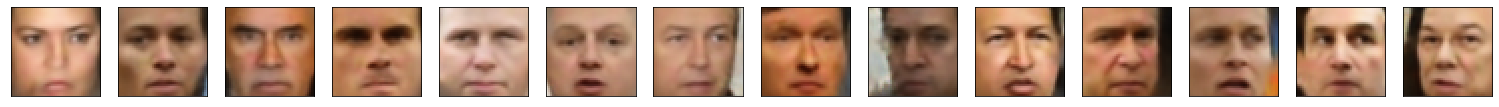

smile vector + sad person


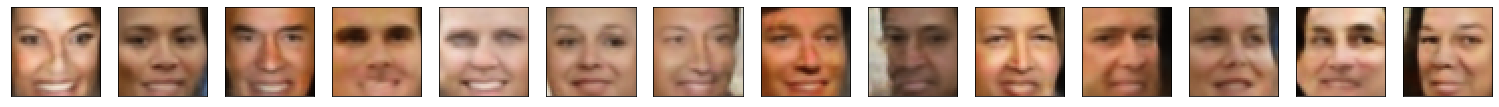

sad vector + sad person to make them much sadder


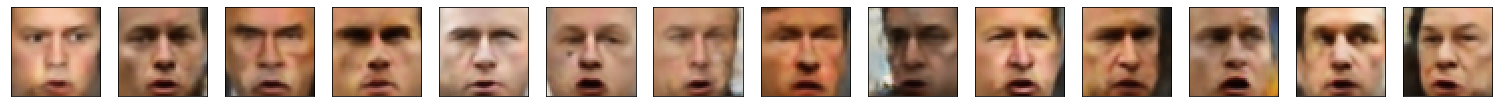

In [27]:
with torch.no_grad():

    indx = []
    number_guys = 14
    for i in range(number_guys):
        indx.append(random.randint(0, batch_for_non_smile.shape[0]-1))

    # random sad fellow

    sad = model.encoder_part(batch_for_non_smile[indx])

    sad2happy = sad + smile_vector

    sad2happy = model.decoder_part(sad2happy)


    print('sad people')
    plot_gallery(batch_for_non_smile[indx].permute(0, 2, 3, 1).cpu(), 45,45, n_row=1, n_col=number_guys)
    plt.show()

    print("let's look at ability of our decoder to reconstruct")
    sad_decoder = model.decoder_part(sad)
    plot_gallery(sad_decoder.permute(0, 2, 3, 1).cpu(), 45,45, n_row=1, n_col=number_guys)
    plt.show()

    print('smile vector + sad person')
    plot_gallery(sad2happy.permute(0, 2, 3, 1).cpu(), 45,45, n_row=1, n_col=number_guys)
    plt.show()

    too_sad = sad + sad_vector
    too_sad = model.decoder_part(too_sad)
    print('sad vector + sad person to get them much sadder')
    plot_gallery(too_sad.view(-1,3,45,45).permute(0, 2, 3, 1).cpu(), 45,45, n_row=1, n_col=number_guys)
    plt.show()
    